In [46]:
from edges_analysis.analysis.filters import RMSInfo
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from scipy.ndimage import median_filter
from typing import List, Tuple
from edges_analysis import read_step
from edges_cal.xrfi import detrend_medfilt, flagged_filter, robust_divide

### Look at RMSInfo

In [68]:
rms = RMSInfo.from_file("/home/smurray/data4/Projects/radio/EOR/Edges/projects_with_nive/edges-bowman2018-pipeline/main_pipeline/rms_info_np.h5")

(0.0, 50.0)

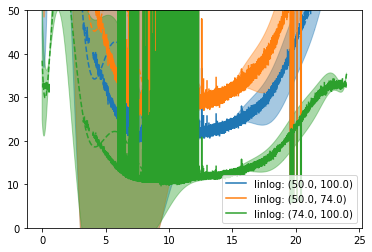

In [69]:
rms.plot()
plt.ylim(0, 50)

In [70]:
infiles = sorted(Path('/home/smurray/edges/Steven/edges-cache/level-cache/nature-paper/no-rms/linlog5-25/').glob("*.h5"))

/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/smur

/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/smur

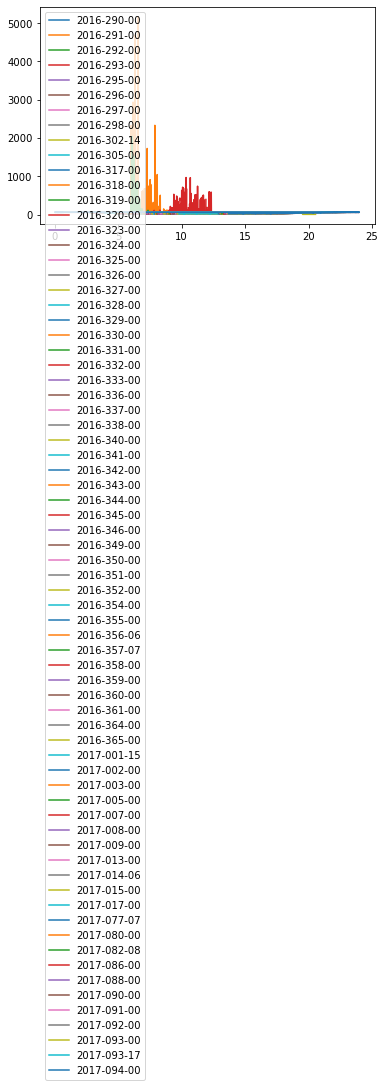

In [71]:
for day in infiles:
    day290 = read_step(day)
    resids = np.where(day290.weights, day290.resids, np.nan)
    rms = np.sqrt(np.nanmean(resids**2, axis=1))
#    rms[np.isnan(rms)|np.isinf(rms)] = np.nan
    rms[rms==0] = np.nan
    plt.plot(day290.gha, rms, label=day290.datestring)
plt.legend()

In [11]:
combo = read_step("/home/smurray/edges/Steven/edges-cache/level-cache/nature-paper/no-rms/linlog5-25/bin05-xrfi-model/all-files.h5")

/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


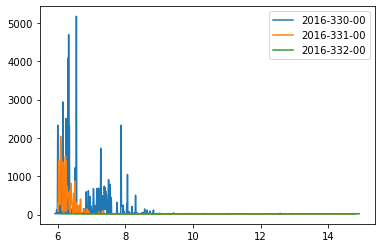

In [74]:
for day in [330, 331, 332]:
    mdl = combo.get_day(day)
    resids = np.where(mdl.weights, mdl.resids, np.nan)
    rms = np.sqrt(np.nanmean(resids**2, axis=1))
#    rms[np.isnan(rms)|np.isinf(rms)] = np.nan
    rms[rms==0] = np.nan
    plt.plot(mdl.gha, rms, label=mdl.datestring)
plt.legend()

In [12]:
day330 = combo.get_day(330)
day290 = combo.get_day(290)

<AxesSubplot:title={'center':'2016-330-00. GHA0=18.30'}, xlabel='Frequency [MHz]', ylabel='Hours into Observation'>

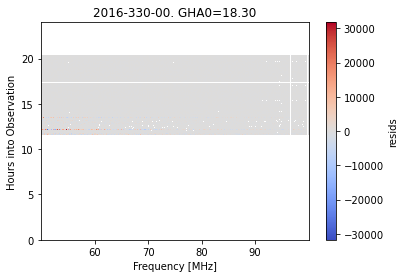

In [77]:
day330.plot_waterfall('resids')

### Look at Total Power Filter

In [131]:
tp = np.nanmean(np.where(day330.weights, day330.spectrum,np.nan), axis=1)

/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


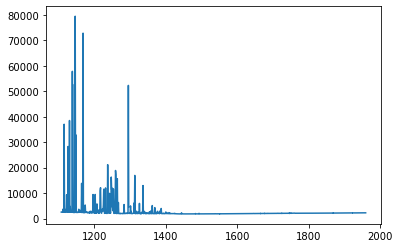

In [132]:
plt.plot(tp)

In [144]:
from typing import List, Tuple

def total_power_filter(
    gha: np.ndarray,
    spectra: np.ndarray,
    frequencies: np.ndarray,
    flags: [None, np.ndarray] = None,
    n_poly: int = 3,
    n_sigma: float = 3.0,
    bands: [None, List[Tuple[float, float]]] = None,
    std_thresholds=None,
    width: int=100
):
    """
    Filter on total power.

    The algorithm of the filter is:

    Get the sum of each spectrum (for a night/day) in three different bands (low half,
    upper half, total) (yielding, for each band, a "total power" as a function of GHA).
    For each band, split the total power into smallish chunks of GHA (nominally 1hr bins),
    and for each bin, fit a low-order polynomial to the total power.
    GHA's whose total power is outside some threshold are flagged, and the previous step
    is repeated, until no new GHAs are flagged. This threshold is itself thresholded:
    if the RMS of the residuals of the fit are very large, even 1-sigma outliers are
    flagged. Otherwise, only 3-4-sigma outliers are flagged.


    Parameters
    ----------
    gha : array_like
        1D array of galactic hour angles
    spectra
        2D array where first dimension is length GHA and corresponds to different
        integrations, and second dimension corresponds to frequency.
    frequencies
        The frequencies at which the spectra are defined.
    flags
        Any flagged entries in the spectra (2D array, shape (GHA, freq)).
    n_poly
        The number of polynomial terms to fit to each 1-hour GHA bin.
    n_sigma
        The number of sigma at which to threshold individual integrations.
    bands
        A list of tuples, each with two floats: min and max of a frequency band over
        which to take the total power. By default, use the whole band only.
    std_thresholds
        The absolute threshold for each band in terms of the standard deviation of
        residuals. If very high, then individual integrations will be flagged at
        one sigma deviation rather than ``n_sigma``. Must be the same length as ``bands``
        if given.

    """
    # Set the relevant frequency bands over which to take the total powers.
    if bands is None:
        bands = [(frequencies.min(), frequencies.max())]

    for i, band in bands:
        if band is None:
            bands[i] = (frequencies.min(), frequencies.max())

    assert spectra.shape == (len(gha), len(frequencies)), "total_power has wrong shape"

    if flags is None:
        flags = np.zeros(spectra.shape, dtype=bool)

    flags_1d = np.prod(flags, axis=1).astype(bool)

    # Now sum over the frequency bands.
    total_power = np.zeros((len(bands), len(gha)))
    for i, band in enumerate(bands):
        freq_mask = (frequencies >= band[0]) & (frequencies < band[1])
        total_power[i] = np.nanmean(np.where((~flags) | freq_mask, spectra, np.nan), axis=1)

    if std_thresholds is None:
        std_thresholds = [np.inf] * len(bands)
    
    res_collect = {}
    std_collect = {}
    tp_collect = {}
    mdl_collect = {}
    init_flags = {}
    gha_collect = {}
    flg_collect = {}
    
    for j, (tpi, std_threshold, band) in enumerate(zip(total_power, std_thresholds, bands)):
        # First flag really bad stuff
        expected_mean = mean_power_model(gha, bands[j][0], bands[j][1])
        flags_1d |= ((total_power[j] < expected_mean/3) | (total_power[j] > expected_mean*3))

        flg_collect[band], res_collect[band], std_collect[band], mdl_collect[band], tp_collect[band], gha_collect[band], init_flags[band] = gha_based_poly_filter_in_chunks(
            tpi, gha, flags=flags_1d, std_threshold=std_threshold, gha_bin_size=gha_bin_size,
            n_poly=n_poly, std_estimator=std_estimator
        )
        
        flags_1d |= flg_collect[-1]
        
    return flags_1d, flg_collect, res_collect, std_collect, tp_collect, mdl_collect, init_flags, gha_collect, total_power

def gha_based_poly_filter_in_chunks(
    data, gha, flags=None, std_threshold=np.inf, gha_bin_size=1,
    n_poly=3, std_estimator='medfilt'
):
    if flags is None:
        flags = np.zeros(len(data), dtype=bool)
        
    res_collect = {}
    std_collect = {}
    tp_collect = {}
    mdl_collect = {}
    init_flags = {}
    gha_collect = {}
    flg_collect = {}
    
    for i, gha_min in enumerate(range(0, 24, gha_bin_size)):
        mask = (gha >= gha_min) & (gha < gha_min + gha_bin_size)
        
        this_gha = gha[mask]
        this_extern_flags = flags[mask]
        this_data = data[mask]
        this_extern_flags |=  np.isnan(this_data)

        # If enough data points available per hour
        if np.sum(~this_extern_flags) <= 10:
            print(f"continuing GHA {i}")
            flags[mask] = True
            continue

        res, std, mdl, flg = gha_based_poly_filter(
            this_data, this_gha, this_extern_flags.copy(), n_poly=n_poly, 
            std_estimator=std_estimator, std_threshold=std_threshold,
        )
        res_collect[i] = res
        std_collect[i] = std
        mdl_collect[i] = mdl
        flg_collect[i] = flg
        tp_collect[i] = this_tp
        gha_collect[i] = this_gha
        init_flags[i] = this_extern_flags

        flags[mask] = flg[-1]

    return flg_collect, res_collect, std_collect, mdl_collect, tp_collect, gha_collect, init_flags
            
def gha_based_poly_filter(data, gha, flags=None, n_poly: int=3, std_estimator: str='medfilt', std_threshold: float=np.inf):
    if flags is None:
        flags = np.zeros(len(data), dtype=bool)
        
    intern_flags = flags | np.isnan(data)
    
    res_collect = []
    std_collect = []
    mdl_collect = []
    flg_collect = []
    
    nflags = -1
    while nflags < np.sum(intern_flags):
        nflags = np.sum(intern_flags)

        if (len(this_gha) - nflags) < n_poly:
            # If we've flagged too much, just get rid of everything here.
            intern_flags[:] = True
            break
        
            
        par = np.polyfit(gha[~intern_flags], data[~intern_flags], n_poly - 1)
        model = np.polyval(par, this_gha)
        res = data - model

        if std_estimator == 'medfilt':
            sig = np.sqrt(flagged_filter(res**2, size=2*(width//2)+1, kind="median", flags=this_intern_flags) / 0.456)
        elif std_estimator == 'absres':
            absres = np.abs(res)
            sigpar = np.polyfit(gha[~intern_flags], absres[~intern_flags], n_poly-1)
            sig = np.polyval(sigpar, gha)
        elif std_estimator == 'std':
            sig = np.std(res)*np.ones_like(gha)
        elif std_estimator == 'mad':
            sig = _get_mad(res) * np.ones_like(gha)
            
        zscore = robust_divide(res, sig)

        mask = sig > std_threshold
        intern_flags[mask] = flags[mask] | (zscore[mask] > 1)
        intern_flags[~mask] = flags[~mask] | (zscore[~mask] > n_sigma)

        res_collect.append(res)
        std_collect.append(sig)
        mdl_collect.append(model)
        flg_collect.append(intern_flags)
        
    return res_collect, std_collect, mdl_collect, flg_collect
            
def _get_mad(x):
    med = np.median(x)
    # Factor of 0.456 to scale median back to Gaussian std dev.
    return np.median(np.abs(x - med)) / np.sqrt(0.456)


def mean_power_model(gha, nu_min, nu_max, beta=-2.5):
    """A really rough model of expected mean power between two frequencies"""
    t75 = 1750*np.cos(np.pi*gha/12) + 3250  # approximate model based on haslam
    return (t75/((beta+1)*75.0**beta)*(nu_max**(beta+1) - nu_min**(beta+1)))/(nu_max-nu_min)
    
def _get_polyfit_res_std(n_poly, gha, data, flags=None):
    if flags is None:
        flags = np.zeros(len(gha), dtype=bool)

    if np.sum(~flags) < n_poly:
        raise np.linalg.LinAlgError("After flagging, too few data points left for n_poly.")

    par = np.polyfit(gha[~flags], data[~flags], n_poly - 1)

    model = np.polyval(par, gha)
    res = data - model
    absres = np.abs(res)
    
#    std_par = np.polyfit(gha[~flags], absres[~flags])
    std = _get_mad(res[~flags])

    return res, std, model

In [116]:
flags, res, std, tpp, mdl, iflags, ghac, tp330 = total_power_filter(
    day330.gha,
    day330.spectrum,
    day330.raw_frequencies,
    flags= day330.weights ==0,
    n_poly = 3,
    n_sigma = 3.0,
    bands = None,
    std_thresholds=[10],
    width=75
)
tp330 = tp330[0]

/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice


nflags after nans:  94
nflags after expected mean:  94
continuing GHA 0
nflags after nans:  95
nflags after expected mean:  95
continuing GHA 1
nflags after nans:  94
nflags after expected mean:  94
continuing GHA 2
nflags after nans:  97
nflags after expected mean:  97
continuing GHA 3
nflags after nans:  96
nflags after expected mean:  96
continuing GHA 4
nflags after nans:  88
nflags after expected mean:  88
continuing GHA 5
nflags after nans:  1
nflags after expected mean:  10
nflags through iterating:  20
nflags through iterating:  29
nflags through iterating:  36
nflags through iterating:  40
nflags through iterating:  44
nflags through iterating:  46
nflags through iterating:  48
nflags through iterating:  49
nflags through iterating:  49
nflags after everything:  49
nflags after nans:  4
nflags after expected mean:  20
nflags through iterating:  33
nflags through iterating:  39
nflags through iterating:  41
nflags through iterating:  42
nflags through iterating:  42
nflags afte

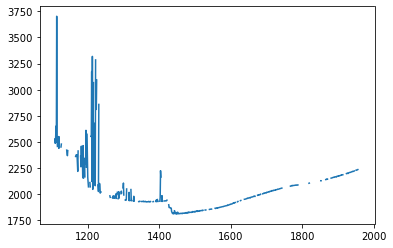

In [117]:
plt.plot(np.where(flags, np.nan, tp330))
#plt.xlim(1100,1125)

In [ ]:
for day in combo.days:
    dobj = combo.get_day(day)
    
    

In [98]:
flags, res, std, tpp, mdl, iflags, ghac, tp290 = total_power_filter(
    day290.gha,
    day290.spectrum,
    day290.raw_frequencies,
    flags= day290.weights ==0,
    n_poly = 3,
    n_sigma = 3.0,
    bands = None,
    std_thresholds=[5],
)
tp290 = tp290[0]

/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice
/data4/smurray/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/xrfi.py:165: UserWarning: Setting default mode to reflect because a large size was set.
  "Setting default mode to reflect because a large size was set."
/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


nflags after nans:  94
nflags after expected mean:  94
continuing GHA 0
nflags after nans:  95
nflags after expected mean:  95
continuing GHA 1
nflags after nans:  72
nflags after expected mean:  72
nflags through iterating:  72
nflags after everything:  72
nflags after nans:  1
nflags after expected mean:  1
nflags through iterating:  1
nflags after everything:  1
nflags after nans:  0
nflags after expected mean:  0
nflags through iterating:  0
nflags after everything:  0
nflags after nans:  3
nflags after expected mean:  3
nflags through iterating:  5
nflags through iterating:  5
nflags after everything:  5
nflags after nans:  1
nflags after expected mean:  1
nflags through iterating:  2
nflags through iterating:  2
nflags after everything:  2
nflags after nans:  0
nflags after expected mean:  0
nflags through iterating:  0
nflags after everything:  0
nflags after nans:  2
nflags after expected mean:  2
nflags through iterating:  3
nflags through iterating:  3
nflags after everything

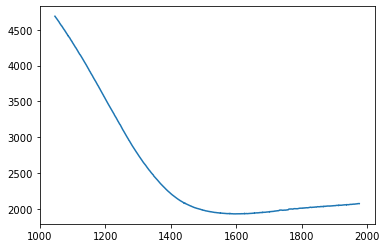

In [99]:
plt.plot(np.where(flags, np.nan, tp290))

### Use Median Filter

In [145]:
from bisect import bisect_left, insort

def my_median_filter(data, width, flags=None):
    result = np.empty_like(data)
    ndata = len(data)
    if flags is None:
        flags = np.zeros(len(data), dtype=bool)
    
    flags[np.isnan(data)] = True
    
    # Want the local median, so use data on both sides of current point.
    
    # Find the first non-flagged bit of data.
    l = []
    jdx = 0
    half_width = (width+1)//2
    while all(flags[jdx:half_width+jdx]):
        result[jdx] = data[jdx]
        jdx += 1
    
    l = sorted(list(data[jdx:half_width + jdx][~flags[jdx:half_width + jdx]]))
        
    lsize = len(l)
        
    low_idx = (jdx-1)-(width+1)//2
    hi_idx = (jdx-1) + (width+1)//2
    
    for idx in range(jdx, ndata):
        if low_idx >= 0:
            # Remove the point unless it was flagged
            old_flg = flags[low_idx]

            if not old_flg:
                del l[bisect_left(l, data[low_idx])]
                lsize -= 1
        
        if hi_idx < ndata:
            flg = flags[hi_idx]
            if not flg:
                new_elem = data[hi_idx]
                insort(l, new_elem)
                lsize += 1
            
        low_idx += 1
        hi_idx += 1
        
        result[idx] = l[(lsize - 1) // 2]
    return result

def total_power_filter_medfilt(
    gha: np.ndarray,
    spectra: np.ndarray,
    frequencies: np.ndarray,
    width: int=50,
    flags=None,
    n_sigma: float = 3.0,
    bands: [None, List[Tuple[float, float]]] = None,
    std_thresholds=None,
):
    """
    Filter on total power.

    The algorithm of the filter is:

    Get the sum of each spectrum (for a night/day) in three different bands (low half,
    upper half, total) (yielding, for each band, a "total power" as a function of GHA).
    For each band, split the total power into smallish chunks of GHA (nominally 1hr bins),
    and for each bin, fit a low-order polynomial to the total power.
    GHA's whose total power is outside some threshold are flagged, and the previous step
    is repeated, until no new GHAs are flagged. This threshold is itself thresholded:
    if the RMS of the residuals of the fit are very large, even 1-sigma outliers are
    flagged. Otherwise, only 3-4-sigma outliers are flagged.


    Parameters
    ----------
    gha : array_like
        1D array of galactic hour angles
    spectra
        2D array where first dimension is length GHA and corresponds to different
        integrations, and second dimension corresponds to frequency.
    frequencies
        The frequencies at which the spectra are defined.
    flags
        Any flagged entries in the spectra (2D array, shape (GHA, freq)).
    n_poly
        The number of polynomial terms to fit to each 1-hour GHA bin.
    n_sigma
        The number of sigma at which to threshold individual integrations.
    bands
        A list of tuples, each with two floats: min and max of a frequency band over
        which to take the total power. By default, use the whole band only.
    std_thresholds
        The absolute threshold for each band in terms of the standard deviation of
        residuals. If very high, then individual integrations will be flagged at
        one sigma deviation rather than ``n_sigma``. Must be the same length as ``bands``
        if given.

    """
    # Set the relevant frequency bands over which to take the total powers.
    if bands is None:
        bands = [(frequencies.min(), frequencies.max())]

    for i, band in bands:
        if band is None:
            bands[i] = (frequencies.min(), frequencies.max())

    assert spectra.shape == (len(gha), len(frequencies)), "total_power has wrong shape"

    if flags is None:
        flags = np.zeros(spectra.shape, dtype=bool)

    # Now sum over the frequency bands.
    total_power = np.zeros((len(bands), len(gha)))
    for i, band in enumerate(bands):
        freq_mask = (frequencies >= band[0]) & (frequencies < band[1])
        total_power[i] = np.nanmean(np.where((~flags) | freq_mask, spectra, np.nan), axis=1)

    if std_thresholds is None:
        std_thresholds = [None] * len(bands)

    flags_1d = np.prod(flags, axis=1).astype(bool)

    for j, (tpi, std_threshold) in enumerate(zip(total_power, std_thresholds)):
        this_extern_flags = flags_1d | np.isnan(tpi)
        
        print("nflags after nans: ", np.sum(this_extern_flags))

        # First flag really bad stuff
        expected_mean = mean_power_model(gha, bands[j][0], bands[j][1])
        this_extern_flags |= ((tpi < expected_mean/3) | (tpi > expected_mean*3))

        # init_flags[i] = this_extern_flags.copy()

        print('nflags after expected mean: ', np.sum(this_extern_flags))
        # If enough data points available per hour
        lx = np.sum(~this_extern_flags)

        if lx <= 10:
            flags_1d[:] = True
            return flags_1d

        nflags = -1

        
        this_intern_flags = this_extern_flags.copy()
        
        filt_list = []
        std_list = []
        flg_list = []
        while nflags < np.sum(this_intern_flags):
            nflags = np.sum(this_intern_flags)

            if np.sum(~this_intern_flags) < 10:
                # If we've flagged too much, just get rid of everything here.
                flags_1d[:] = True
                break
            else:
                #filtered = my_median_filter(tpi, width, this_intern_flags)
                #res = tpi - filtered
                #std = _get_mad(res[~this_intern_flags])
                filtered = flagged_filter(
                    tpi, size=2*(width//2)+1, kind="median", flags=this_intern_flags, interp_flagged=True
                )

                d_rs = tpi - filtered
                d_sq = d_rs ** 2
                
                sig = np.sqrt(flagged_filter(d_sq, size=2*(width//2)+1, kind="median", flags=this_intern_flags) / 0.456)
                zscore = robust_divide(d_rs, sig)
                
#                detrend_medfilt(tpi, half_size=(50,), flags=this_intern_flags, interp_flagged=True)
                if std_threshold is not None:
                    this_intern_flags = this_extern_flags | (sig > std_threshold)
                else:
                    this_intern_flags = this_extern_flags.copy()
                    
                this_intern_flags = this_intern_flags | (np.abs(zscore) > n_sigma)

                filt_list.append(zscore)
                std_list.append(sig)
                flg_list.append(this_intern_flags.copy())
            print("nflags through iterating: ", np.sum(this_intern_flags))
        
        flags_1d |= this_intern_flags

        print("nflags after everything: ", np.sum(flags_1d))
            
    return flags_1d, this_extern_flags, filt_list, std_list, total_power, flg_list

#### Test Median Filter

In [385]:
a = np.linspace(0, 1, 2000) + np.random.normal(0, 0.1, size=2000)

In [386]:
flags = np.zeros(len(a), dtype=bool)
flags[::200] = True
flags[:200] = True
b = my_median_filter(a, 100, flags=flags)

In [387]:
%timeit my_median_filter(a, 50, flags=flags)

4 ms ± 75.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


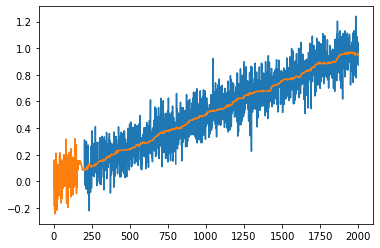

In [388]:
plt.plot(np.where(flags, np.nan, a))
plt.plot(b)

In [401]:
t = np.linspace(0, 2*np.pi, 2000)
a = 100*np.cos(t) + np.random.normal(0, 5, size=2000)
a[::50] = 2000
b = my_median_filter(a, width=100)

In [402]:
_get_mad(a-b)

5.150286949678592

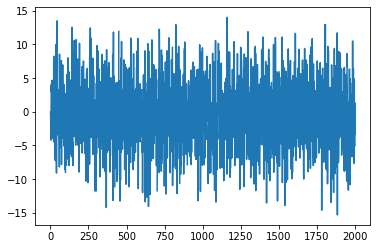

In [404]:
flg = np.abs(a-b) > 3*_get_mad(a-b)
plt.plot(np.where(flg, np.nan, a-b))
#plt.plot(b)

#### Test Median TP Filter

In [69]:
flags, iflags, filts, stds, tp290, flg_list = total_power_filter_medfilt(
    day290.gha,
    day290.spectrum,
    day290.raw_frequencies,
    flags= day290.weights ==0,
    n_sigma = 3.0,
    bands = None,
    width=100,
    std_thresholds=[100]
)
tp290 = tp290[0]

/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: Mean of empty slice
/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


nflags after nans:  1350
nflags after expected mean:  1350
nflags through iterating:  1383
nflags through iterating:  1386
nflags through iterating:  1410
nflags through iterating:  1417
nflags through iterating:  1437
nflags through iterating:  1446
nflags through iterating:  1469
nflags through iterating:  1484
nflags through iterating:  1506
nflags through iterating:  1517
nflags through iterating:  1536
nflags through iterating:  1542
nflags through iterating:  1577
nflags through iterating:  1573
nflags after everything:  1573


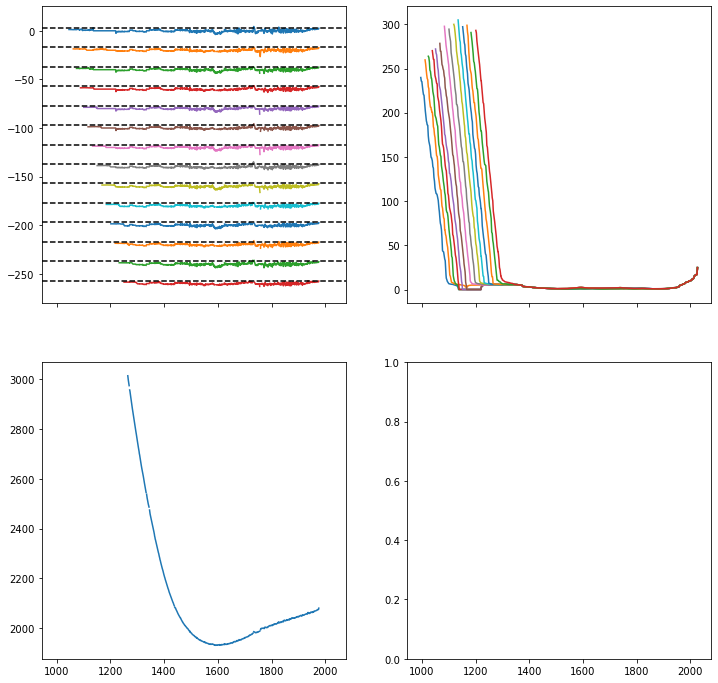

In [70]:
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(12, 12))

for i, flt in enumerate(filts):
    flg = iflags if not i else flg_list[i-1]
    ax[0,0].plot(np.where(flg, np.nan, flt) - i*20)
    ax[0,0].axhline(3 - i*20, color='k', ls='--')

    ax[0,1].plot(stds[i])
    
ax[0,0].set_ylim(-len(filts)*20, 25)

ax[1,0].plot(np.where(flags, np.nan, tp290))

In [34]:
np.all(flags.repeat(len(day330.raw_frequencies)).reshape(len(day330.gha), -1)[:, 0])

False

In [64]:
flags, iflags, filts, stds, tp330, flg_list = total_power_filter_medfilt(
    day330.gha,
    day330.spectrum,
    day330.raw_frequencies,
    flags= day330.weights ==0,
    n_sigma = 3.0,
    bands = None,
    width=25,
)

flags2, iflags2, filts2, stds2, tp3302, flg_list2 = total_power_filter_medfilt(
    day330.gha,
    day330.spectrum,
    day330.raw_frequencies,
    flags= flags.repeat(len(day330.raw_frequencies)).reshape(len(day330.gha), -1),
    n_sigma = 3.0,
    bands = None,
    width=50,
)

tp330 = tp330[0]
tp3302 = tp3302[0]


/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: Mean of empty slice
/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


nflags after nans:  1468
nflags after expected mean:  1495
nflags through iterating:  1610
nflags through iterating:  1615
nflags through iterating:  1626
nflags through iterating:  1641
nflags through iterating:  1640
nflags after everything:  1640
nflags after nans:  1640
nflags after expected mean:  1640
nflags through iterating:  1657
nflags through iterating:  1656
nflags after everything:  1656


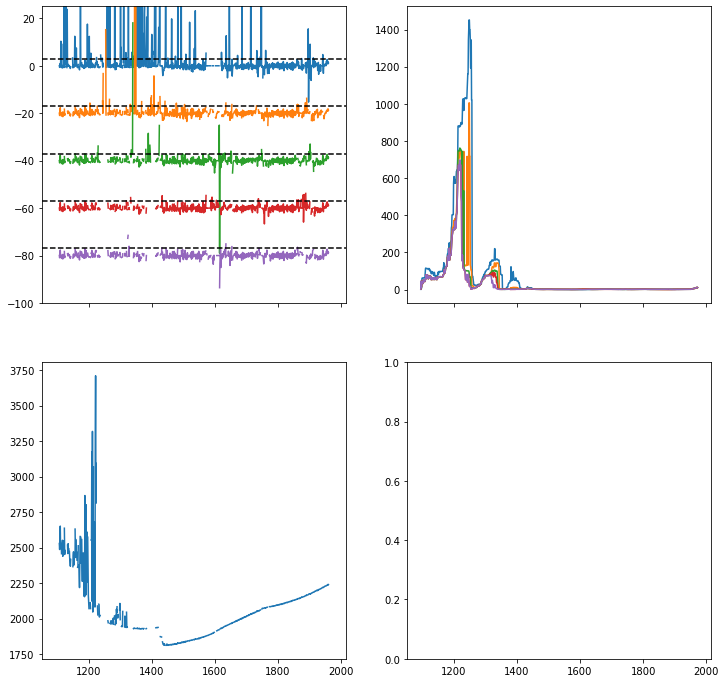

In [65]:
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(12, 12))

for i, flt in enumerate(filts):
    flg = iflags if not i else flg_list[i-1]
    ax[0,0].plot(np.where(flg, np.nan, flt) - i*20)
    ax[0,0].axhline(3 - i*20, color='k', ls='--')

    ax[0,1].plot(stds[i])
    
ax[0,0].set_ylim(-len(filts)*20, 25)

ax[1,0].plot(np.where(flags, np.nan, tp330))

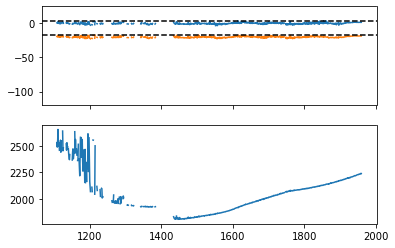

In [42]:
fig, ax = plt.subplots(2, 1, sharex=True)
for i, flt in enumerate(filts2):
    flg = iflags2 if not i else flg_list2[i-1]
    ax[0].plot(np.where(flg, np.nan, flt) - i*20)
    ax[0].axhline(3 - i*20, color='k', ls='--')
    
ax[0].set_ylim(-len(filts)*20, 25)

ax[1].plot(np.where(flags2, np.nan, tp3302))

(1500.0, 3000.0)

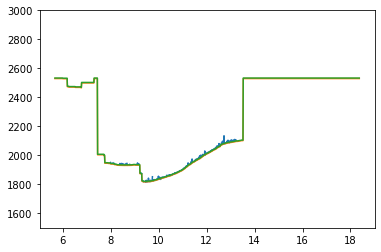

In [356]:
plt.plot(day330.gha, np.where(flags, np.nan, tp))
plt.plot(day330.gha, filts[-1])
plt.plot(day330.gha, filts[-1] + 3*stds[-1])
plt.ylim(1500, 3000)

In [165]:
p = np.polyfit(ghac[6][~iflags[6]], tpp[6][~iflags[6]], 2)

In [175]:
model = np.polyval(p, ghac[6])
res = tpp[6] - model
std = _get_mad(res[~iflags[6]])

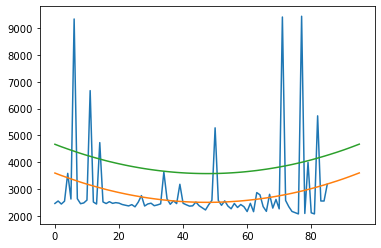

In [176]:
plt.plot(tpp[6][~iflags[6]])
plt.plot(model)
plt.plot(model + 3*std)

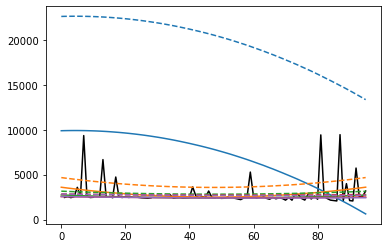

In [179]:
plt.plot(np.where(iflags[6], np.nan, tpp[6]), color='k')
for i, (m, s) in enumerate(zip(mdl[6], std[6])):
    plt.plot(m, color=f"C{i}")
    plt.plot(m+3*s, ls='--', color=f"C{i}")

In [150]:
np.sum(~flags)

802

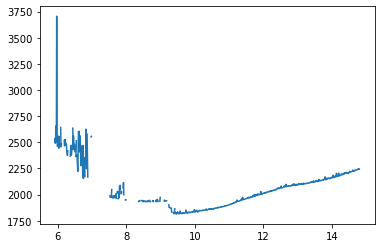

In [180]:
plt.plot(day330.gha, np.where(flags, np.nan, tp))

In [43]:
day302 = read_step('/home/smurray/edges/Steven/edges-cache/level-cache/nature-paper/no-rms/linlog5-25/2016-302-14.h5')

In [51]:
day302.gha[100]


8.470602620607192

In [53]:
np.where(np.abs(day290.gha - 8.47) < 0.1)[0][0]

1469

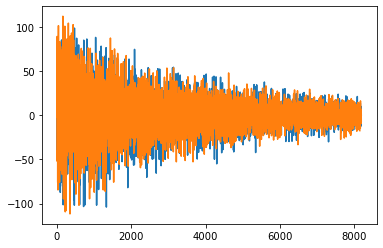

In [60]:
plt.plot(np.where(day302.weights[100]==0, np.nan, day302.resids[100]))
plt.plot(np.where(day290.weights[1469]==0, np.nan, day290.resids[1469]))

In [62]:
np.sqrt(np.nanmean(np.where(day302.weights[100]==0, np.nan, day302.resids[100])**2))

20.103337634011545

In [63]:
np.sqrt(np.nanmean(np.where(day290.weights[1469]==0, np.nan, day290.resids[1469])**2))

20.099284330217788

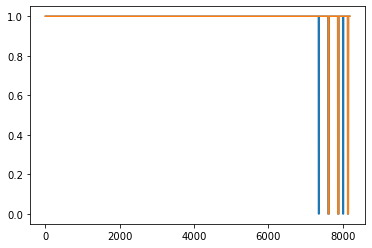

In [61]:
plt.plot(day302.weights[100])
plt.plot(day290.weights[1469])

<AxesSubplot:title={'center':'2016-302-14. GHA0=7.39'}, xlabel='Frequency [MHz]', ylabel='Hours into Observation'>

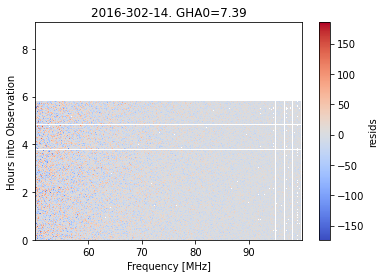

In [44]:
day302.plot_waterfall(quantity='resids')

In [31]:
rms292 = np.sqrt(np.nanmean(day292.resids**2, axis=1))

/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [33]:
np.nanmax(day292.resids)

176378.385960084

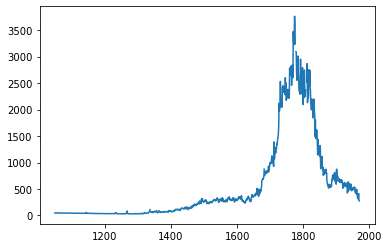

In [32]:
plt.plot(rms292)

<AxesSubplot:title={'center':'2016-290-00. GHA0=15.69'}, xlabel='Frequency [MHz]', ylabel='Hours into Observation'>

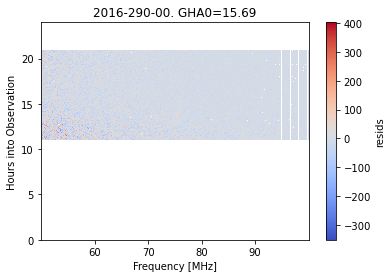

In [17]:
day290.plot_waterfall(quantity='resids')

### Try fitting on multiple nights.

In [127]:
day_tp = {}
day_init_flags = {}
ghas = {}
for day in list(combo.days[:20]) + list(combo.days[-20:]):
    dobj = combo.get_day(day)
    flags = dobj.weights == 0
    
    total_power = np.nanmean(np.where(flags, np.nan, dobj.spectrum), axis=1)
    day_tp[day] = total_power
    
    flags = np.prod(flags, axis=1).astype(bool)
    
    expected_mean = mean_power_model(dobj.gha, 50, 100)
    
    flags |= ((total_power < expected_mean/3) | (total_power > expected_mean*3))
    
    ghas[day]  = dobj.gha
    day_init_flags[day] = flags

/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


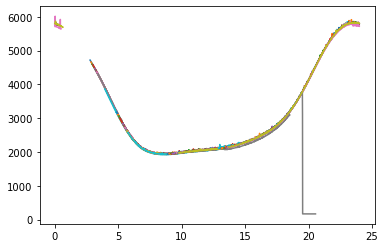

In [129]:
for day, tp in day_tp.items():
    ix = np.argsort(ghas[day])
    plt.plot(ghas[day][ix], tp[ix])

In [132]:
sum?

In [138]:
all_gha = np.array([])
all_tp = np.array([])

for gha, tp in zip(ghas.values(), day_tp.values()):
    all_gha = np.concatenate((all_gha, gha))
    all_tp = np.concatenate((all_tp, tp))

In [139]:
ix = np.argsort(all_gha)
all_gha = all_gha[ix]
all_tp = all_tp[ix]

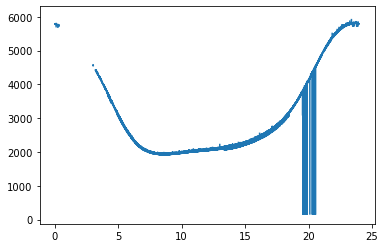

In [140]:
plt.plot(all_gha, all_tp)

In [143]:
flg_collect, res_collect, std_collect, mdl_collect, tp_collect, gha_collect, init_flags = gha_based_poly_filter_in_chunks(
    all_tp, all_gha, std_threshold=np.inf, gha_bin_size=1,
    n_poly=3, std_estimator='medfilt'
)

NameError: name 'this_gha' is not defined

In [141]:
total_power_filter?